In [2]:
using LaTeXStrings
using Plots
using DelimitedFiles

# Error Mitigation using Clifford Data Regression on the IBM Utility Experiment

### Fig 4b)

- Unmitigated data from the utility experiment:
https://www.nature.com/articles/s41586-023-06096-3
- Tensor network results from utility experiment as exact values (we'd need to run PP on the cluster for 127 qubits, 20 layers and machine precision)
- would be nice to have PP results (or any exp. values over time)


In [3]:
include("src/cpa.jl");

In [4]:
data_exp_unmit = Dict{Float64, Array{Float64, 1}}()
open("data/fig4b_experiment_unmit.txt", "r") do f
    for d in eachline(f)
        values = split(d, ",")
        key = parse(Float64, values[1])
        data = [parse(Float64, v) for v in values[2:end]]
        data_exp_unmit[key] = data
        #take mean for every angle
    end
end
IBM_unmitigated_vals = Vector{Float64}()
for i in keys(data_exp_unmit)
    push!(IBM_unmitigated_vals, mean(data_exp_unmit[i]))
end

# from Manuel's notebook
IBM_mitigated_vals = [1.01688859, 1.00387483, 0.95615886, 0.95966435, 0.83946763,
    0.81185907, 0.54640995, 0.45518584, 0.19469377, 0.01301832,0.01016334]
IBM_angles = [0.    , 0.1   , 0.2   , 0.3   , 0.4   , 0.5   , 0.6   , 0.7   , 0.8   , 1.    , 1.5707]

tn_vals = [9.99999254e-01,  9.99593653e-01,  9.95720077e-01,  9.88301532e-01,
        9.78553511e-01,  9.58023054e-01,  9.21986059e-01,  8.81726079e-01,
        8.49816779e-01,  8.24900527e-01,  7.91257641e-01,  7.37435202e-01,
        6.68573798e-01,  5.88096040e-01,  4.81874079e-01,  3.50316579e-01,
        2.26709331e-01,  1.39724659e-01,  7.86639143e-02,  4.24124371e-02,
        1.90595136e-02,  6.18879050e-03, -8.27168956e-04, -4.63372099e-03,
       -7.05202121e-03, -7.68387421e-03, -6.33121142e-03, -4.32594440e-03,
        6.52050191e-04,  1.72598340e-04,  5.64696020e-05, -7.70582375e-07]
tn_angles = LinRange(0, π/2, length(tn_vals));


In [ ]:
angles = collect(keys(data_exp_unmit)); #theta_h

11-element Vector{Float64}:
 0.3
 1.0
 0.7
 0.0
 0.2
 0.8
 0.5
 0.1
 0.4
 1.5707
 0.6

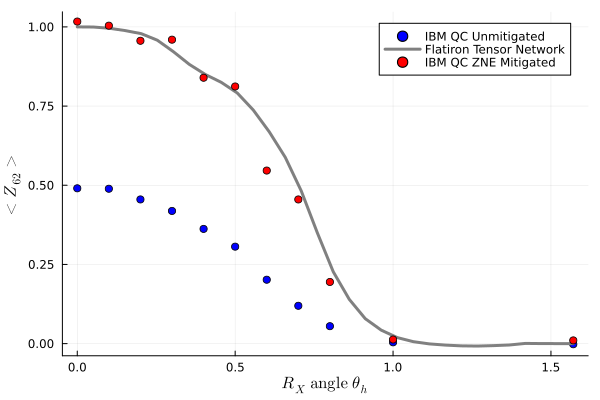

In [19]:
scatter(angles, IBM_unmitigated_vals, label="IBM QC Unmitigated", color=:blue, lw=2, xlabel=L" R_X\  \textrm{angle}\ \theta_h", ylabel=L"<Z_{62}>", legend=:topright)
plot!(tn_angles, tn_vals, label="Flatiron Tensor Network", color="grey", linewidth=3)
scatter!(IBM_angles, IBM_mitigated_vals, label="IBM QC ZNE Mitigated", color="Red", ms=4)

## Our CDR procedure correcting IBM QC data

### Full run test

In [8]:
nq = 127 #number of qubits
topology = ibmeagletopology
nl = 1 #20
observable = PauliSum(nq)
add!(observable, :Z, 62) # different to Manuel
T = nl/20  #time resolution
h = 1.0 
min_abs_coeff = 1e-5; #training set (exact and noisy)
min_abs_coeff_exact = 0.0 #this should be 0 to get
min_abs_coeff_noisy = min_abs_coeff;
sigma_star = pi/20 #for our CPA methods
noise_kind = "gate_kickedising"
trotter = trotter_kickedising_setup(nq, nl, T,h; topology = topology)

trotter_ansatz_tfim(Gate[FrozenGate(PauliRotation([:Z, :Z], [1, 2]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [1, 15]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [2, 3]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [3, 4]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [4, 5]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [5, 6]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [5, 16]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [6, 7]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [7, 8]), parameter = -1.57), FrozenGate(PauliRotation([:Z, :Z], [8, 9]), parameter = -1.57)  …  PauliRotation([:X], [118]), PauliRotation([:X], [119]), PauliRotation([:X], [120]), PauliRotation([:X], [121]), PauliRotation([:X], [122]), PauliRotation([:X], [123]), PauliRotation([:X], [124]), PauliRotation([:X], [125]), PauliRotation([:X], [126]), PauliRotation([:X], [127])], Gate[FrozenGate(PauliRotation([:Z, :Z], [1, 2]), 

In [9]:
print("sigma_h = ", trotter.sigma_h, " sigma_J = ", trotter.sigma_J,"    pi/20 = ", pi/20)

sigma_h = 0.1 sigma_J = -1.5707963267948966    pi/20 = 0.15707963267948966

In [10]:
global_logger(UnbufferedLogger(stdout, SubInfo))
exact_expval_target, noisy_expval_target, corr_energy, rel_error_before, rel_error_after = full_run(trotter, sigma_star, noise_kind; min_abs_coeff, min_abs_coeff_noisy, observable = observable,num_samples = 5, record = true, cdr_method = "end", use_target = false, real_qc_noisy_data = IBM_unmitigated_vals[2])

[SubInfo] ready to ruuuuuummmble
[Error] Exception while generating log record in module Main at /home/julia/julia_scripts/pp-em/cdr/src/cpa.jl:755
[SubInfo] noisy_training_time_evolution done in 0.42 s
[SubInfo] cdr method end done in 4.03 s


(NaN, 0.004107759335343423, 0.004191163488769649, NaN, NaN)

# Smaller example (3 layers)

In [20]:
#trunction max_weight = 8, min_abs_coeff = 1e-4
corr_energy_strict_CPA_test = [0.7065161069772835, 0.013895199657957873, 0.3035052000959395, 1.0, 0.7297057122670905, 0.10201787586056714, 0.5625003211705719, 0.9964411572367162, 0.6821403023215343, 0.0, 0.35455599923322173]
corr_energy_strict_CPA_mw_10_abs_coeff_5 = [0.6559830795209787, 0.03757020163515776, 0.19871428844432265, 1.0, 0.7633298810612551, 0.08399958457748205, 0.5364756304558803, 0.9964229052022745, 0.5811603963242845, 0.0, 0.3619722848587214]
corr_energy_loose_small_mw_20_abs_coeff_5 = [0.9862160830390639, 0.9669770894085417, 0.9762834018844588, 1.0, 0.988234604903283, 0.9729353433717342, 0.9854083989538537, 0.9964229075384101, 0.9834148070672105, 0.0, 0.9731305461407511]
corr_energy_strict_small_mw_20_abs_coeff_5 = [0.9865422476520838, 0.9576113603343447, 0.9724810024695617, 0.9898424993388746, 0.9892628495178973, 0.9621033115360978, 0.9784855412596822, 0.990437911007951, 0.987422244782197, 0.9640772278026617, 0.9798932897544947]

11-element Vector{Float64}:
 0.9865422476520838
 0.9576113603343447
 0.9724810024695617
 0.9898424993388746
 0.9892628495178973
 0.9621033115360978
 0.9784855412596822
 0.990437911007951
 0.987422244782197
 0.9640772278026617
 0.9798932897544947

In [21]:
pi/20 #so, first 2 values are exact (there should only be same sample in data set for all samples)


0.15707963267948966

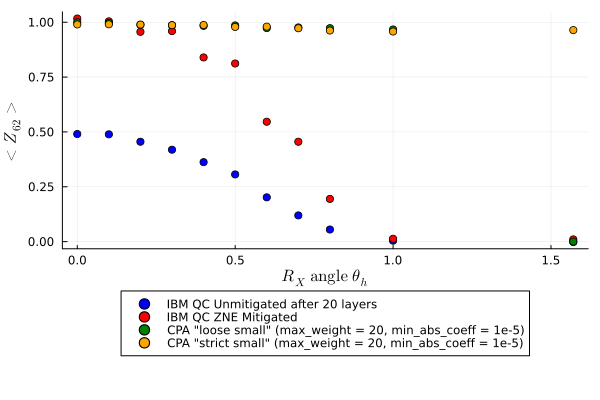

In [23]:
##plot the results (just to get an idea)
scatter(angles, IBM_unmitigated_vals, label="IBM QC Unmitigated after 20 layers", color=:blue, lw=2, xlabel=L" R_X\  \textrm{angle}\ \theta_h", ylabel=L"<Z_{62}>", legend=:outerbottom)
scatter!(IBM_angles, IBM_mitigated_vals, label="IBM QC ZNE Mitigated", color="Red", ms=4)
scatter!(angles, corr_energy_loose_small_mw_20_abs_coeff_5, label="CPA \"loose small\" (max_weight = 20, min_abs_coeff = 1e-5)", color="green", linewidth=3)
scatter!(angles, corr_energy_strict_small_mw_20_abs_coeff_5, label="CPA \"strict small\" (max_weight = 20, min_abs_coeff = 1e-5)", color="orange", linewidth=3)

### Fig 2c)

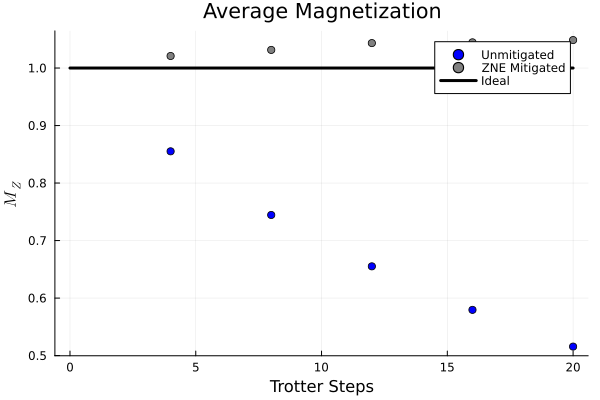

In [14]:
#sigma_h = 0 here 
#fig 2c data)
unmit_mean = [0.85518705, 0.74448575, 0.65517617, 0.57949265, 0.51562281]
unmit_error_low = [0.00053715, 0.00061151, 0.00082803, 0.00079234, 0.00068535]
unmit_error_high = [0.00044692, 0.00073607, 0.00089438, 0.00081071, 0.00060498]


### ZNE mititgation results
mit_mean = [1.02093006, 1.03148792, 1.04337926, 1.04468239, 1.04863588]
mit_error_low = [0.00559543, 0.00629862, 0.0096018 , 0.01002338, 0.01663647]
mit_error_high = [0.00308734, 0.01891702, 0.01161069, 0.01864672, 0.0164886]

trotter_steps = [4,8,12,16,20]

scatter(trotter_steps, unmit_mean, label="Unmitigated", color=:blue, lw=2, xlabel="Trotter Steps", ylabel=L"M_Z", title="Average Magnetization", legend=:topright)
scatter!(trotter_steps, mit_mean, label="ZNE Mitigated", color="grey", linewidth=3)

#true value at 1 -line
plot!([0, 20], [1, 1], label="Ideal", color="black", linewidth=3)